In [1]:
import psycopg2, psycopg2.extras, psycopg2.pool, json
from multiprocessing import Pool, Manager
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import seaborn as sns
import pandas as pd
%matplotlib inline

# Contributor Density
Since each tile varies in area depending on it's latitude, we have processed each tile at the per-km level. The results are stored in the `users-per-sqkm` database.

This notebook connects to this database and then tracks individual users present each year on each square kilometer inside of each tile.

It takes the _average per year_ for these, and tracks the _running average_ (while maintaining unique users).

### Connect to the `users-per-sqkm` database

In [2]:
d = "dbname=users-per-sqkm user=anderstj host=127.0.0.1"
conn1 = psycopg2.pool.ThreadedConnectionPool(1, 50, dsn=d)
CURSOR = conn1.getconn().cursor( cursor_factory = psycopg2.extras.DictCursor)

study_tiles = json.loads(open('study_tiles_with_compare_tiles.json','r').read())
print("Found {0} tiles.".format(len(study_tiles)))

Found 9 tiles.


In [3]:
def get_year_data(year, quad):
    string = "SELECT * FROM tiles_per_year_%s "%(year)
    CURSOR.execute(string + "where quadkey = %s",(quad,))
    return CURSOR.fetchall()

In [4]:
def get_annual_averages(quadkey):
    quad_sections  = {}
    years          = []
    print(quadkey,end=" ")

    for year in [2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016]:
        print(".",end="")
        res_coll = get_year_data(year, quadkey)
        this_year = {'year':year, 'annual_mappers_per_sq_km':[]}
        for res in res_coll:
            qa = res[3]            
            this_year['annual_mappers_per_sq_km'].append(len(np.unique(res[5])) / res[4] )

            section_id = res[2]

#             if len(res[5]):             #There has to be something here, don't inflate with zeroes for empty map
            if section_id in quad_sections: 
                quad_sections[section_id]['users']+= res[5]
            else:
                quad_sections[section_id] = {'users':res[5], 'a':res[4]} 
        #Within each year, get the running average as it counts the users
        running_avg = []
        users = []
        for a, data in quad_sections.items():
            users_per_sqkm = len(np.unique(data['users'])) / data['a']
            running_avg.append(users_per_sqkm)
            users += data['users']
        
        this_year['running_average'] = np.average(running_avg)
        this_year['annual_average']  = np.average(this_year['annual_mappers_per_sq_km'])
        this_year['unique_users']    = len(np.unique(users))

        years.append(this_year)
        
    df = pd.DataFrame(years)
    df['tile_area'] = qa
    df['users_over_area'] = df.unique_users / df.tile_area
    return df

In [5]:
for tile in study_tiles:
    tile['df'] = get_annual_averages(tile['quad'])
    print(tile['name'])

032211203001 ............Port Au Prince, Haiti
123131221200 ......

/usr/local/lib/python3.4/dist-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


......Trisuli Bazar, Nepal
132312223332 ............Tacloban, Philippines
033330200220 ............Kenema, Sierra Leone
033330222101 ............Monrovia, Liberia
123131221232 ............Kathmandu, Nepal
120203320232 ............Heidelberg, Germany
031313131103 ............London, UK
032010110132 ............Manhattan, NY


In [6]:
for i, t in enumerate(study_tiles):
    print(i, t['name'])

0 Port Au Prince, Haiti
1 Trisuli Bazar, Nepal
2 Tacloban, Philippines
3 Kenema, Sierra Leone
4 Monrovia, Liberia
5 Kathmandu, Nepal
6 Heidelberg, Germany
7 London, UK
8 Manhattan, NY


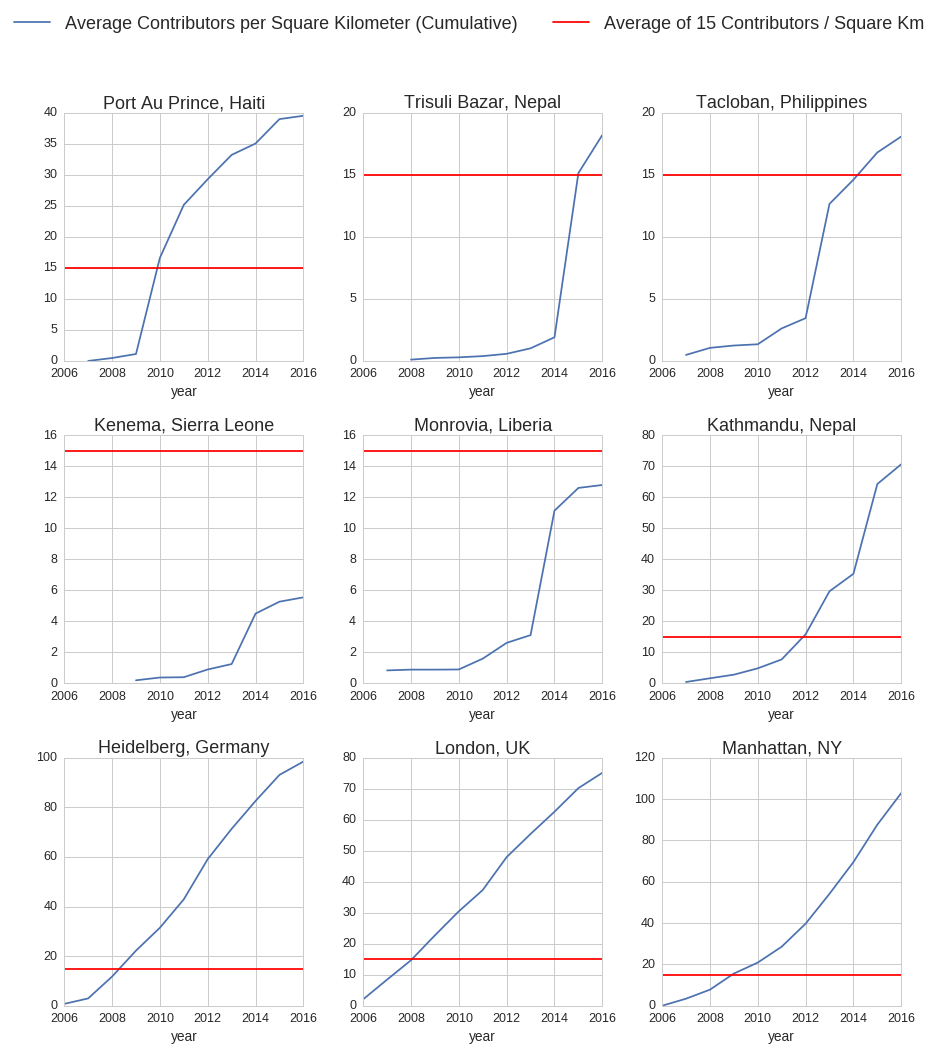

In [7]:
sns.set(font_scale=1.25)
plt.style.use('seaborn-whitegrid')
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15,16), facecolor='w', edgecolor='k')
plt.subplots_adjust(wspace=0.25, hspace=0.3)

for ax, (idx, tile) in zip(axs.ravel(), enumerate(study_tiles)):
    
    df = tile['df']
    
    df.plot(ax=ax,x='year', y='running_average', legend=False)
    
#     df['total_active_users']  = df.users_new_obj + df.users_edited_obj
    
    ax.plot([2006,2016],[15,15], color='red')

    ax.set_xlim(2006,2016)
    ax.set_title(tile['name'],fontsize=18)
    
plt.figlegend( ax.get_lines(),
              [ "Average Contributors per Square Kilometer (Cumulative)",
                "Average of 15 Contributors / Square Km"],
                 loc = ('upper center'), ncol=3, fontsize=18)

## Interpretation

For very popular areas of the map such as Manhattan or London, we see a fairly constant rate of growth in the number of contributors per square kilometer.

For areas of the map which have been the subject of disaster mapping, the time of activation is... quite obvious

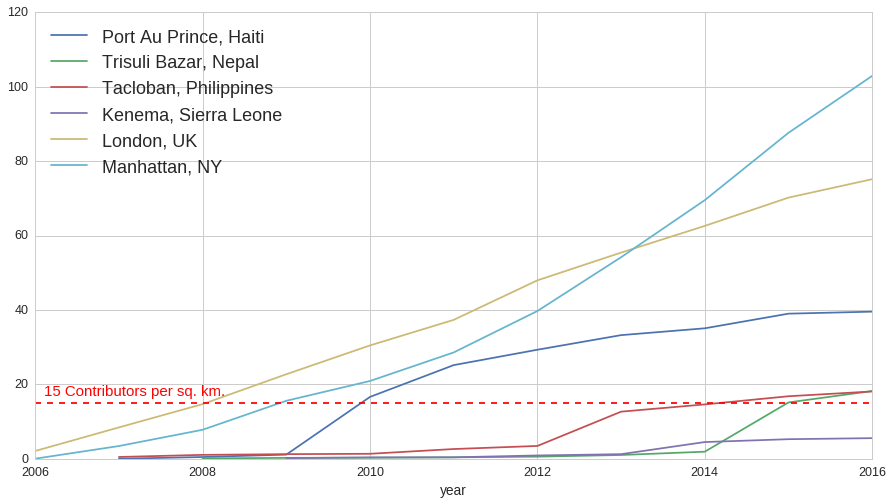

In [8]:
sns.set(font_scale=1.25)
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(1)
fig.set_size_inches(15,8)
labels = []

for tile in study_tiles[:4]+study_tiles[-2:]:

    df = tile['df']
    
    df.plot(ax=ax,x='year', y='running_average', legend=False)
    
    ax.set_xlim(2006,2016)
    
    labels.append(tile['name'])


ax.plot([2006,2016],[15,15], color='red', linestyle='--')
ax.text(2006.1,17,"15 Contributors per sq. km.", color='red')
plt.legend( ax.get_lines(), labels, loc = 'upper left', fontsize=18)

Here is how a few of these tiles measure up to one-another. Haklay identified in 2010 that 15 contributors per sq. km. is the point at which data became 'very good' (and comparable to official survey data in the region).

### How big is each tile? 
Tiles are different sizes because of different latitudes in the pseudo-mercator projection. Tiles near the equator are upwards of 90 square kilometers.

In [9]:
for tile in study_tiles:
    print(tile['name'])
    print(tile['df'].tile_area.values[0])

Port Au Prince, Haiti
85.9822
Trisuli Bazar, Nepal
74.6887
Tacloban, Philippines
92.1003
Kenema, Sierra Leone
93.9436
Monrovia, Liberia
94.5831
Kathmandu, Nepal
75.0104
Heidelberg, Germany
40.5223
London, UK
37.0372
Manhattan, NY
54.9418


# How do study tiles compare to _similar tiles_?

### 1. Iterate through study tiles, fetching stats for all comparable tiles

In [10]:
for tile in study_tiles:
    print("\r" + tile['name'], len(tile['compare_tiles']))
    for t in tile['compare_tiles']:
        t['df'] = get_annual_averages(t['quad'])

Port Au Prince, Haiti 8
120213000002 ............120221033031 ........

/usr/local/lib/python3.4/dist-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


Trisuli Bazar, Nepal 4
Tacloban, Philippines 1
Kenema, Sierra Leone 0
Monrovia, Liberia 1
Kathmandu, Nepal 0
Heidelberg, Germany 37
London, UK 17
Manhattan, NY 8
120220011030 ............031331123312 ............120220330313 ............021212222131 ............030222231030 ............032010033002 ............023010230020 ............032300212020 ............

# Compare Study Tiles to Average of Similar Tiles

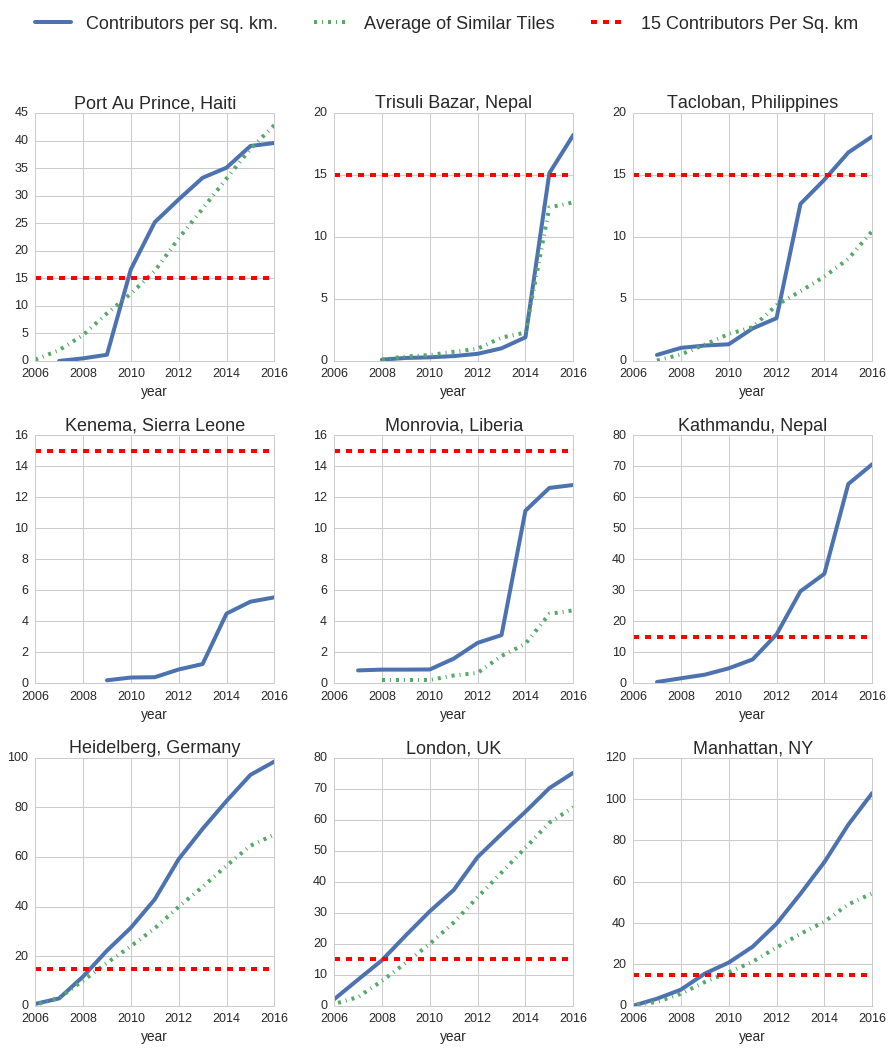

In [11]:
sns.set(font_scale=1.25)
plt.style.use('seaborn-whitegrid')
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15,16), facecolor='w', edgecolor='k')
plt.subplots_adjust(wspace=0.25, hspace=0.3)


for ax, (idx, tile) in zip(axs.ravel(), enumerate(study_tiles)):
    
    ax = tile['df'].plot(ax=ax,x='year',y='running_average',lw=4)

    if len(tile['compare_tiles'])>0:
        compare_df = pd.DataFrame()
        for t in tile['compare_tiles']:
            compare_df = pd.concat([compare_df,t['df']])

        avg = compare_df.groupby('year').aggregate({'running_average' : pd.Series.mean})
        avg.plot(ax=ax, y='running_average',linestyle="-.",lw=4)

    ax.set_xlim(2006,2016)
    
    ax.set_title(tile['name'])

    line, = ax.plot([2006,2016],[15,15], color='red', linestyle='--',lw=4)
    
    ax.legend_.remove()
    handles, labels = ax.get_legend_handles_labels()

    ax.set_title(tile['name'], fontsize=18)

plt.figlegend( [handles[0],handles[1], line],
               ["Contributors per sq. km.","Average of Similar Tiles", "15 Contributors Per Sq. km"], 
               loc=('upper center'), ncol=3, fontsize=18)

In [50]:
for i, t in enumerate(study_tiles):
    print(i, t['name'])

0 Port Au Prince, Haiti
1 Trisuli Bazar, Nepal
2 Tacloban
3 Kenema, Sierra Leone
4 Monrovia, Liberia
5 Kathmandu, Nepal
6 Heidelberg, Germany
7 London
8 Manhattan, NY


In [59]:
study_tiles[2]['name'] = "Tacloban, Philippines"
study_tiles[7]['name'] = "London, United Kingdom"

## Create Plot for Paper

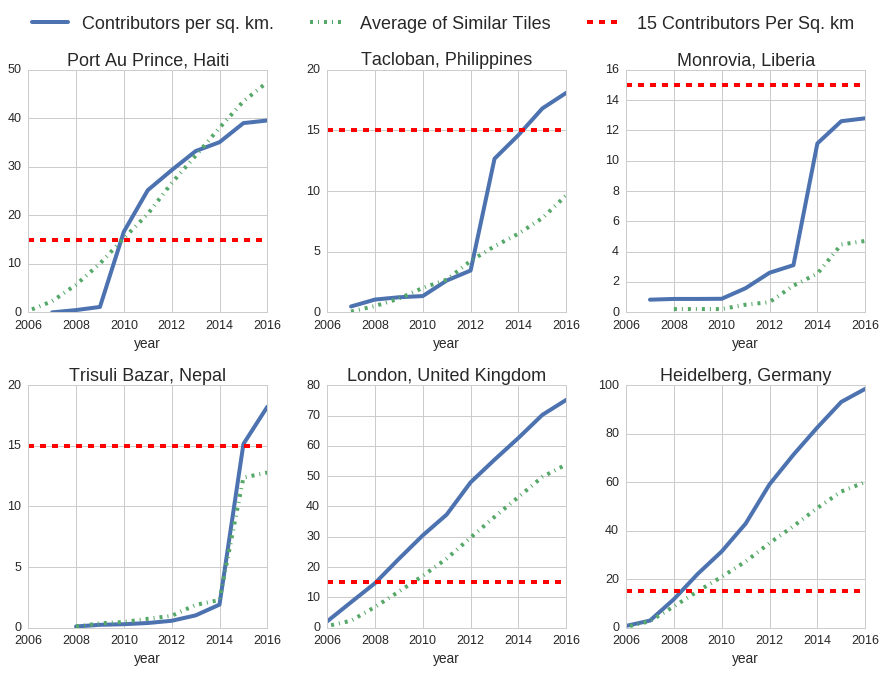

In [60]:
sns.set(font_scale=1.25)
plt.style.use('seaborn-whitegrid')
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15,10), facecolor='w', edgecolor='k')
plt.subplots_adjust(wspace=0.25, hspace=0.3)

indices_to_plot = [0,2,4,1,7,6]

st = [study_tiles[x] for x in indices_to_plot]

for ax, (idx, tile) in zip(axs.ravel(), enumerate(st)):
    
    ax = tile['df'].plot(ax=ax,x='year',y='running_average',lw=4)

    if len(tile['compare_tiles'])>0:
        compare_df = pd.DataFrame()
        for t in tile['compare_tiles']:
            compare_df = pd.concat([compare_df,t['df']])

        avg = compare_df.groupby('year').aggregate({'running_average' : pd.Series.mean})
        avg.plot(ax=ax, y='running_average',linestyle="-.",lw=4)

    ax.set_xlim(2006,2016)
    
    ax.set_title(tile['name'])

    line, = ax.plot([2006,2016],[15,15], color='red', linestyle='--',lw=4)
    
    ax.legend_.remove()
    handles, labels = ax.get_legend_handles_labels()

    ax.set_title(tile['name'], fontsize=18)

plt.figlegend( [handles[0],handles[1], line],
               ["Contributors per sq. km.","Average of Similar Tiles", "15 Contributors Per Sq. km"], 
               loc=('upper center'), ncol=3, fontsize=18)